# Imports

In [1]:
import pandas as pd
import numpy as np
import os, inspect
main_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) 
RGCPD_dir = '/'.join(main_dir.split('/')[:-1])
os.chdir(RGCPD_dir)
from RGCPD import RGCPD
from RGCPD import BivariateMI
import class_BivariateMI, functions_pp
from stat_models_cont import ScikitModel
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV
import func_models as fc_utils

%load_ext autoreload
%autoreload 2

# main directory is the directory of this notebook


# my main directory (which contains folders with data etc)
my_main_dir = '/Users/semvijverberg/surfdrive/output_RGCPD/Mozambique_forecast/'
ERA5_path = '/Users/semvijverberg/surfdrive/ERA5/input_raw'

# Define paths for target variable (TV), precursors data and test data

In [2]:
# directory of target variable data
TV_path_jfm = os.path.join(my_main_dir, 'SPI_Gabi', 'SPI_JFM.1982_2020.nc')
TV_path_ond = os.path.join(my_main_dir, 'SPI_Gabi', 'SPI_OND.1982_2019.nc')

# directory of precursor data
prec_path = os.path.join(ERA5_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

# Function to make predictions

In [3]:
def pred(prediction, rg, q=0.66):   
    if prediction == 'continuous':
        model = ScikitModel(Ridge, verbosity=0)
        alphas = list(np.concatenate([[1E-20],np.logspace(-5,0, 6), np.logspace(.01, 2.5, num=25)]))                       
        kwrgs_model = {'scoringCV':'neg_mean_absolute_error', 'kfold':10, 'alpha':alphas, 'fit_intercept':False} 
    
    elif prediction == 'events':
        model = ScikitModel(LogisticRegressionCV, verbosity=0)
        kwrgs_model = {'kfold':10, 'scoring':'neg_brier_score'}
        
    
    target_ts = rg.TV.RV_ts
    target_ts = (target_ts - target_ts.mean()) / target_ts.std()
    
    if prediction == 'events':
        if q >= 0.5:
            target_ts = (target_ts > target_ts.quantile(q)).astype(int)
        elif q < .5:
            target_ts = (target_ts < target_ts.quantile(q)).astype(int)
    
        BSS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).BSS
        score_func_list = [BSS, fc_utils.metrics.roc_auc_score]

    
    elif prediction == 'continuous':
        RMSE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).RMSE
        MAE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).MAE
        score_func_list = [RMSE_SS, fc_utils.corrcoef, MAE_SS]

    out = rg.fit_df_data_ridge(target=target_ts,
                            keys=list(rg.df_data.columns[1:-2]),
                            fcmodel=model,
                            kwrgs_model=kwrgs_model,
                            transformer=None,
                            tau_min=0, tau_max=0) # <- lag should be zero     # lags
        
    predict, weights, model_lags = out
        
    df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                 rg.df_data.iloc[:,-2:],
                                                                 score_func_list,
                                                                 n_boot = 100,
                                                                 score_per_test=False,
                                                                 blocksize=1,
                                                                 rng_seed=1)
        
        
    lag = 0                          # why do we set lag = 0?
    if prediction == 'events':
        print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
            'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
            'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
            '\nTrain score\n',
            'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
            'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))
    elif prediction == 'continuous':
        print(model.scikitmodel.__name__, '\n', 'Test score\n',
                'RMSE {:.2f}\n'.format(df_test_m.loc[0][lag]['RMSE']),
                'MAE {:.2f}\n'.format(df_test_m.loc[0][lag]['MAE']),
                'corrcoef {:.2f}'.format(df_test_m.loc[0][lag]['corrcoef']),
                '\nTrain score\n',
                'RMSE {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['RMSE']),
                'MAE {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['MAE']),
                'corrcoef {:.2f}'.format(df_train_m.mean(0).loc[lag]['corrcoef']))

# Pipeline

### Parameters definition

In [4]:
# default parameters
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_TVyear = (1983, 2020)
start_end_year = (1982, 2019)
TVdates_aggr = False
ext_annual_to_mon = False 
#method = 'leave_1'
method = 'random_5'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
lags = np.array([['07-01', '09-01'], ['10-01', '12-01']])            # numpy array of lags
periodnames = ['JAS', 'OND']                                         # names of the lags defined in the line above
start_end_TVdate = ('01-01', '01-03')                                # tuple of start and end date of target variable


#lags = np.array([['10-01', '12-01']])            
#periodnames = ['OND']                                         
#start_end_TVdate = ('01-01', '03-01')                                

In [5]:
# function = 
# alpha = 
# FDR_control =  
# distance_eps =
# min_area_in_degrees2 = 
# tfreq = 
# start_end_year = 
# TVdates_aggr = 
# ext_annual_to_mon = 
# method = 
# detrend = 
# labels = 
# pred_type = 
# lags = np.array()
# periodnames = []
# start_end_TVdate = ()

In [6]:
# note that for now we only allow 1 precursor - sst; in the future predefine a list of precursors
def pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, TV_path):
    
    """
    This is a forecasting pipeline function, which uses an RGCPD class object to make predictions for a target variable. It starts 
    by initializing RGCPD (which utilizes BivariateMI class), then it preprocess target variable and precursor(s), splits the data 
    into train and test, calculates correlation maps, cluster the regions together and make predictions. 
    (when I include multiple lags and feature selection add that to the description)

    Parameters
    -----------
    function : function from BivariateMI class
        Function to apply to calculate the bivariate mutual information, suggested: correlation maps (class_BivariateMI.corr_map)

    alpha : float
        Significance threshold, suggested: 0.05

    FDR_control : bool
        Control for multiple hypothesis testing, siggested: True

    distance_eps : int
        The maximum distance between two gridcells for one to be considered as in the neighborhood of the other, only gridcells 
        with the same sign are grouped together, suggested: 500

    min_area_in_degrees2 : int
        The number of samples gridcells in a neighborhood for a region to be considered as a core point. The parameter is proportional 
        to the average size of 1 by 1 degree gridcell, suggested: 5

    tfreq : int
        n-month means instead of n-day means, suggested: 10, if using time_mean_periods set tfreq to None

    start_end_year : tuple
        For computational efficiency load a subset of data in format (start_year, end_year), default is to load all years (start_end_year = None)

    TVdates_aggr : bool
        If True target variable will be aggregated to a single value per year (mean), if TVdates_aggr is True, set tfreq to None

    ext_annual_to_mon : bool
        If tfreq is None and target variable contain one-value-per-year, the target is extended to match the precursor time-axis. 
        If precursors are monthly means, then the target is also extended to monthly values, else daily values. Both are then 
        aggregated to {tfreq} day/monthly means.  The default is True

    method : str or bool
        Refers to the method to split train test, see class_RGCPD.py for options, suggested: leave_1 (if you want to obtain results quickly use random_5)

    detrend : bool
        Refers to linear detrending, suggested: True

    labels : bool
        If true, quick_view_labels is executed on the RGCPD class object

    pred_type : str
        Type of prediction ("continuous" or "events")

    q : int
        Quantile threshold for event definition, suggested: 0.66
    
    lags : numpy array
        lag with respect to the target variable at which to calculate the MI, examples: np.array([1]), np.array([['01-01', '03-01']])
    
    periodnames : list, optional (recommended)
        List of lags names, to avoid lags naming set periodnames = None
    
    start_end_TVdate : tuple
        Tuple of start and end date of target variable ("start","end") = ("mm-dd","mm-dd")
        

    Returns
    -----------
    """
    
    list_of_name_path = [(1, TV_path), ('sst', prec_path)]
    # initialize BMI class
    list_for_MI = [BivariateMI(name='sst', func=function, 
                           alpha=alpha, FDR_control=FDR_control, 
                           lags=lags, 
                           distance_eps=distance_eps, min_area_in_degrees2=min_area_in_degrees2)]
    
    # initialize RGCPD class
    rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=tfreq, 
           start_end_TVdate=start_end_TVdate, 
           start_end_year = start_end_year,
           path_outmain=output_path)
    
    # preprocessing target variable 
    #rg.pp_TV("SPI", kwrgs_core_pp_time = {'start_end_year':start_end_year}, 
     #        TVdates_aggr=TVdates_aggr, ext_annual_to_mon = ext_annual_to_mon, detrend = detrend)
    
    rg.pp_TV("SPI", kwrgs_core_pp_time = {'start_end_year':start_end_TVyear}, 
             TVdates_aggr=TVdates_aggr, ext_annual_to_mon = ext_annual_to_mon, detrend = detrend)
    
    # preprocessing precursors
    rg.pp_precursors()
    
    # train-test split
    rg.traintest(method)
    
    # calculating correlation maps
    rg.calc_corr_maps()
    
    # clustering regions together
    rg.cluster_list_MI()
    
    # rename lags
    if periodnames != None:    
        sst = rg.list_for_MI[0]
        sst.prec_labels['lag'] = ('lag', periodnames)
        sst.corr_xr['lag'] = ('lag', periodnames)

    # plotting correlation maps
    rg.plot_maps_corr()
    
    # plotting significant regions
    rg.quick_view_labels()
    
    # getting MI timeseries
    rg.get_ts_prec()
    
    # if feature_selection = True:
    # here create an optional feature selection procedure
    
    # making predictions
    prediction = pred(pred_type, rg, q)
    return rg

    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

sorting longitude
[1982 2019] ('07-01', '09-01')
[1982 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(31dp, 81%)

Plotting Corr maps sst, split 0, lag JAS
Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag JAS
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [13, 12, 13, 9, 12] regions in total (list of different splits)
Ridge 
 Test score
 RMSE 0.09
 MAE 0.07
 corrcoef 0.45 
Train score
 RMSE 0.46
 MAE 0.45
 corrcoef 0.85


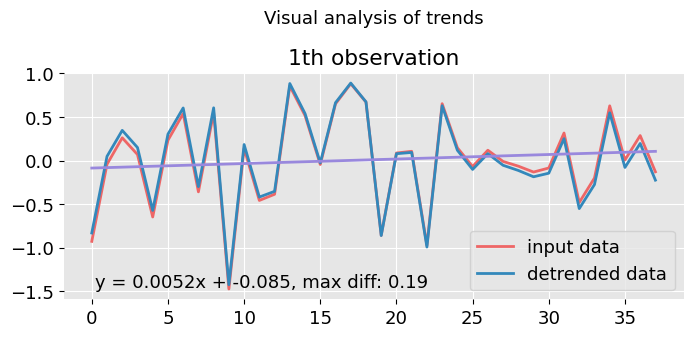

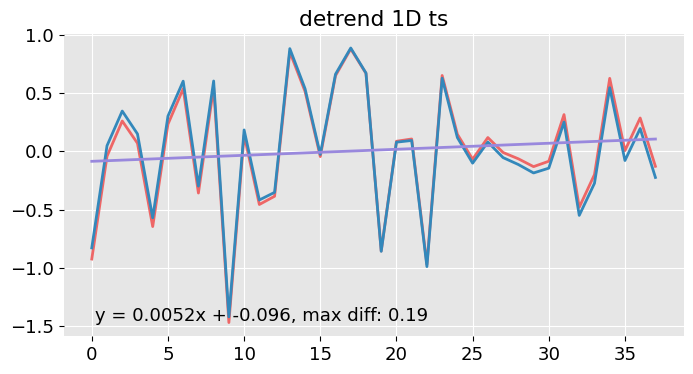

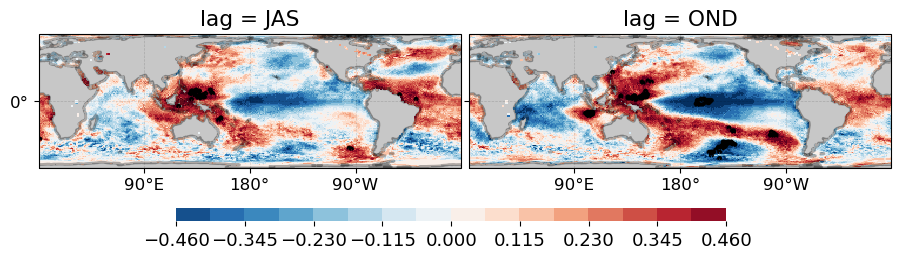

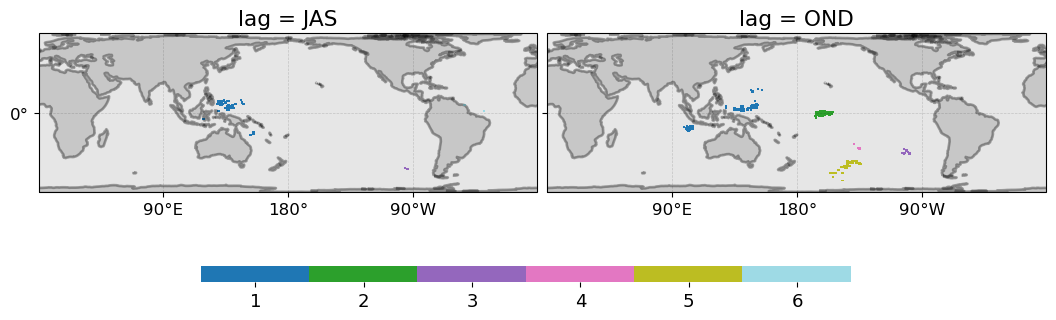

In [7]:
rg = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, TV_path_jfm)

# Cdf_dataous predictions

## Prediction for JFM with a single lag

#### Defining parameters

In [20]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_TVyear = (1982, 2020)
start_end_year = (1981, 2019)# as our target variable is for JFM in years 1982-2020, we need to load precursor data from 1981 up to 2019
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'random_5'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         

start_end_TVdate = ('01-01', '03-01')                                

#### Prediction

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

sorting longitude
[1981 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(32dp, 82%)

Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [10, 8, 8, 8, 10] regions in total (list of different splits)
Ridge 
 Test score
 RMSE 0.11
 MAE 0.11
 corrcoef 0.52 
Train score
 RMSE 0.46
 MAE 0.46
 corrcoef 0.85


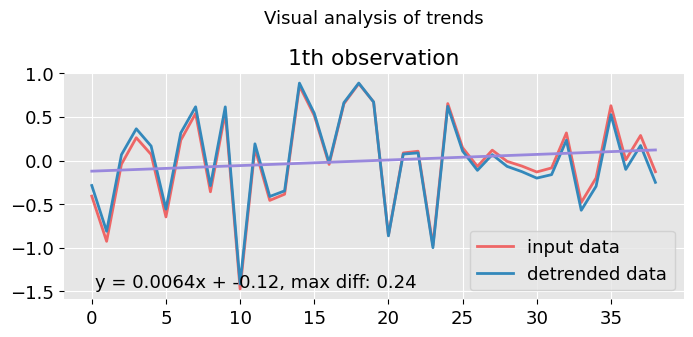

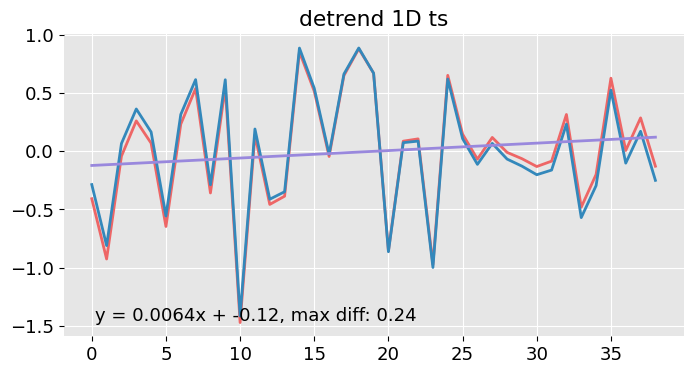

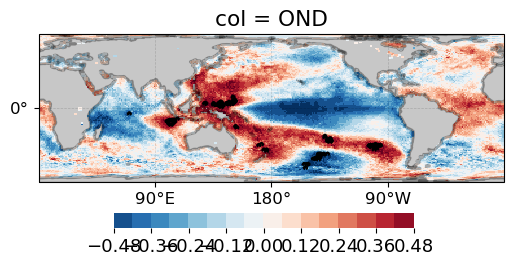

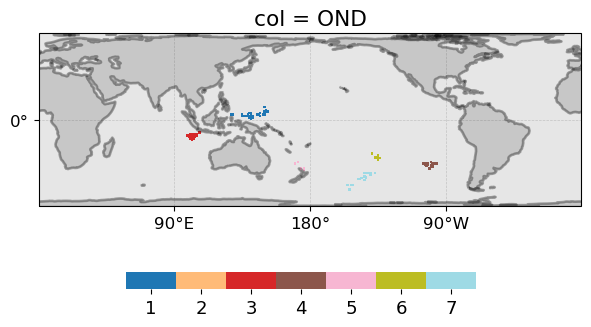

In [21]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, TV_path_jfm)

## Prediction for JFM with multiple lags

In [24]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_TVyear = (1982, 2020)
start_end_year = (1981, 2019) # as our target variable is for JFM in years 1982-2020, we need to load precursor data from 1981 up to 2019
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'random_5'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
lags = np.array([['07-01', '09-01'], ['10-01', '12-01']])            
periodnames = ['JAS', 'OND']                                         

start_end_TVdate = ('01-01', '03-01')                                

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

sorting longitude
[1981 2019] ('07-01', '09-01')
[1981 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(32dp, 82%)

Plotting Corr maps sst, split 0, lag JAS
Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag JAS
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [15, 12, 12, 11, 16] regions in total (list of different splits)
Ridge 
 Test score
 RMSE 0.07
 MAE 0.06
 corrcoef 0.51 
Train score
 RMSE 0.47
 MAE 0.48
 corrcoef 0.86


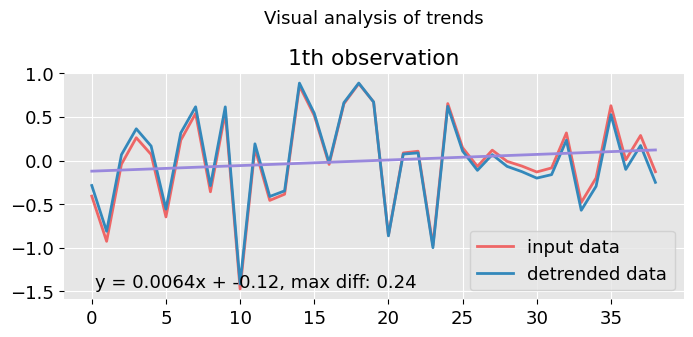

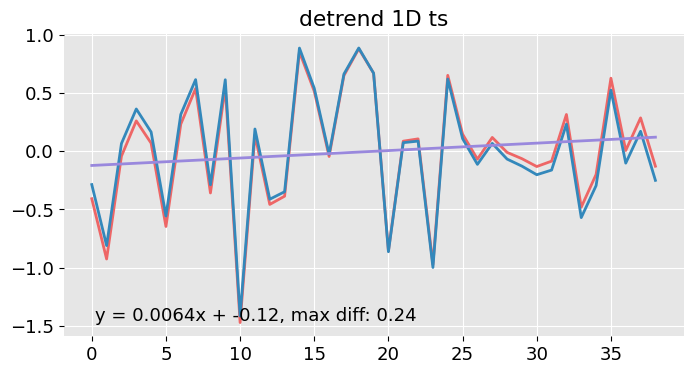

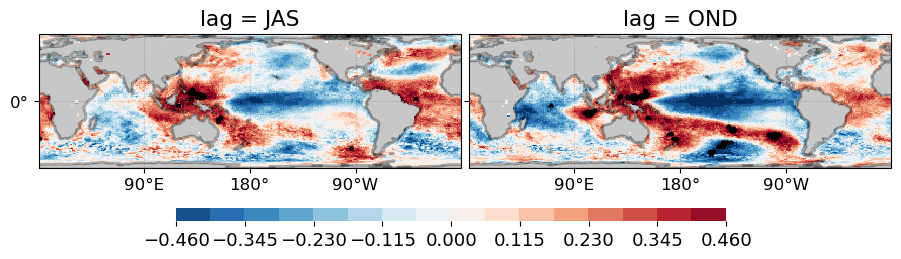

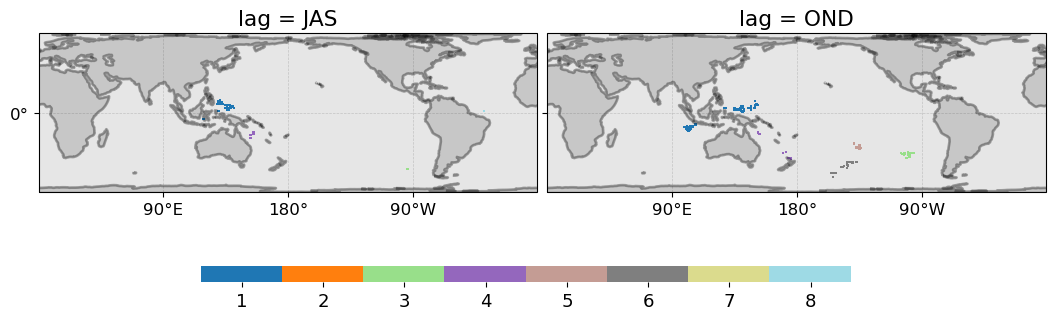

In [25]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, TV_path_jfm)

## Prediction for OND with a single lag

In [26]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_TVyear = (1982, 2019)
start_end_year = (1982, 2019)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         

start_end_TVdate = ('10-01', '12-01')                                

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

sorting longitude
[1982 2019] ('07-01', '09-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(37dp, 97%)

Plotting Corr maps sst, split 0, lag JAS
Plotting Corr maps sst_labels_init, split 0, lag JAS

Getting MI timeseries
There are [3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3] regions in total (list of different splits)
Ridge 
 Test score
 RMSE 0.12
 MAE 0.13
 corrcoef 0.49 
Train score
 RMSE 0.29
 MAE 0.34
 corrcoef 0.71


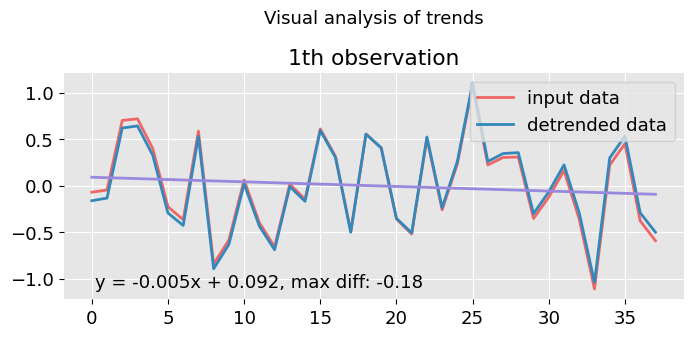

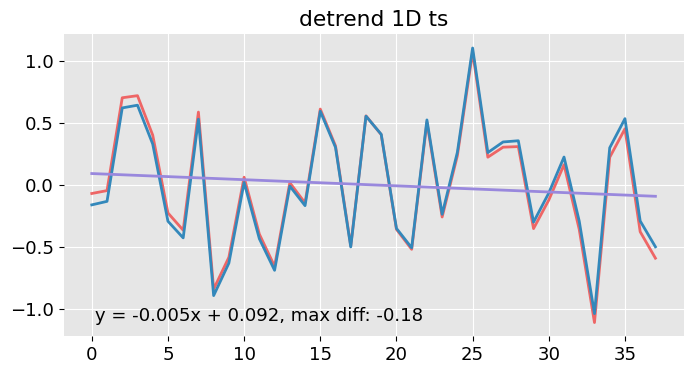

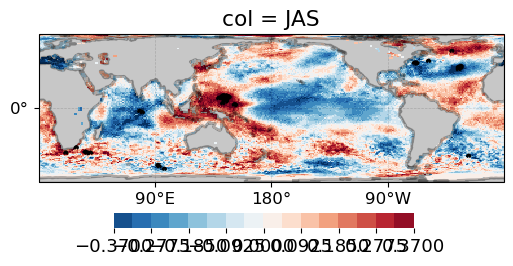

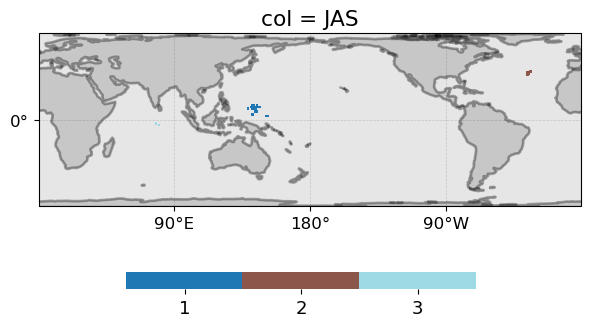

In [27]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, TV_path_ond)

## Prediction for OND with multiple lags

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_TVyear = (1982, 2019)
start_end_year = (1982, 2019)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
lags = np.array([['04-01', '06-01'], ['07-01', '09-01']])            
periodnames = ["AMJ", 'JAS']                                         

start_end_TVdate = ('10-01', '12-01')                                

In [ ]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, TV_path_ond)

# Events predictions

## Prediction for JFM with a single lag

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1982, 2019)
start_end_TVyear = (1983, 2020)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'events'
q = 0.6
lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         

start_end_TVdate = ('01-01', '03-01')                                

In [ ]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate)

## Prediction for JFM with multiple lags

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1982, 2019)
start_end_TVyear = (1983, 2020)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'events'
q = 0.6
lags = np.array([['07-01', '09-01'], ['10-01', '12-01']])            
periodnames = ['JAS', 'OND']                                         

start_end_TVdate = ('01-01', '03-01')                                

In [ ]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate)

## Prediction for OND with a single lag

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1983, 2020)
start_end_TVyear = (1983, 2020)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'events'
q = 0.6
lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         

start_end_TVdate = ('10-01', '12-01')                                

In [ ]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate)

## Prediction for OND with multiple lags

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1983, 2020)
start_end_TVyear = (1983, 2020)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'events'
q = 0.6
lags = np.array([['04-01', '06-01'], ['07-01', '09-01']])            
periodnames = ["AMJ", 'JAS']                                         

start_end_TVdate = ('10-01', '12-01')                                

In [ ]:
pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate)